In [1]:
import numpy as np
import scipy as sp
from utility import get_best_connected, invert, score, get_highest_out_degrees
from data_loader import M,F, benchmark_mapping
rng = np.random.default_rng(0)

The matrices M and F are just about small enough to fit into memory as dense matrices. We convert them for greater flexibility and calculate the sum of all weights in either matrix.

In [2]:
A=M.todense()
B=F.todense()
N=A.shape[0]
print(f"Number of vertices: {N}")
print(f"Total number of edges A: {np.sum(A)}")
print(f"Total number of edges B: {np.sum(B)}")

Number of vertices: 18524
Total number of edges A: 25678942
Total number of edges B: 8900885


To simplify analysis and algorithms, we remove loops from the graph and compute the sum of the remaining weights. It turns out that the male connectome has a total of only 7 of its weight in loops, which justifies the removal of loops for the purpose of analysing the similarity between A and B.

In [3]:
A[np.arange(N),np.arange(N)]=0
B[np.arange(N),np.arange(N)]=0
print(f"Total non-loop edge weights A: {A.sum()}")
print(f"Totoal non-loop edge weights B: {B.sum()}")
print(f"Number of edges A: {np.count_nonzero(A)}")
print(f"Number of edges B: {np.count_nonzero(B)}")

Total non-loop edge weights A: 25678935
Totoal non-loop edge weights B: 8605287
Number of edges A: 4158055
Number of edges B: 2190669


Both the numbers of edges and the edge weight totals of the two graphs are quite different between the two graphs, especially since they are supposed to represent the brains of two individuals of the same species. To get a better feeling for the graphs and their similarities, we make two histograms comparing their total degrees, i.e. the sum of the weights of the in- and out-degrees of each vertex. Since the distribution is rather widespread, we use logarithmic scales. The logarithmic nature of the histograms hides the fact that one vertex of $F$ has total degree 0, i.e., is isolated.

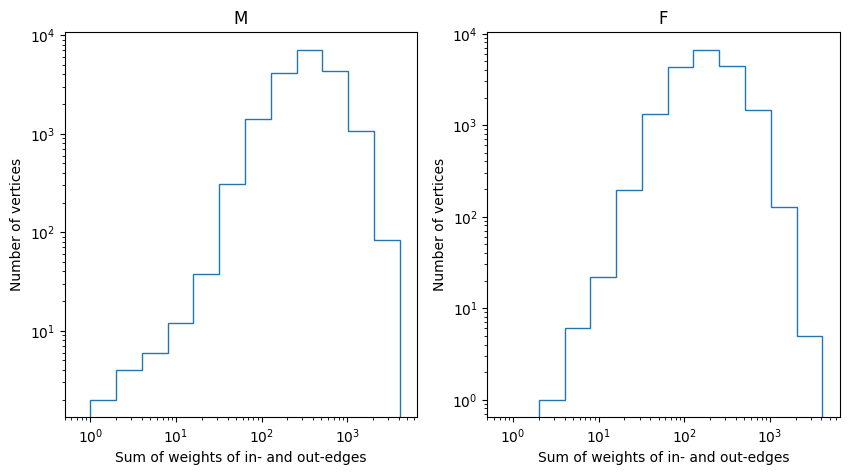

In [22]:
import matplotlib.pyplot as plt

total_degrees_M = (M!=0).astype(dtype=int).sum(axis=1)+(M!=0).astype(dtype=int).sum(axis=0)
total_degrees_F = (F!=0).astype(dtype=int).sum(axis=1)+(F!=0).astype(dtype=int).sum(axis=0)
total_max = max(total_degrees_M.max(), total_degrees_F.max())

figure, subplots = plt.subplots(1, 2)
figure.set_size_inches(10, 5)

values, edges=np.histogram(total_degrees_M, [2**k for k in range(int(np.log2(total_max))+1)])
patch = subplots[0].stairs(values, edges)
subplots[0].set_title("M")
subplots[0].set_xlabel("Sum of weights of in- and out-edges")
subplots[0].set_ylabel("Number of vertices")
patch.axes.set_xscale("log")
patch.axes.set_yscale("log")
patch.axes.set_xlim(.5, total_max)

values, edges=np.histogram(total_degrees_F, [2**k for k in range(int(np.log2(total_max))+1)])
patch = subplots[1].stairs(values, edges)
subplots[1].set_title("F")
subplots[1].set_xlabel("Sum of weights of in- and out-edges")
subplots[1].set_ylabel("Number of vertices")
patch.axes.set_xscale("log")
patch.axes.set_yscale("log")
patch.axes.set_xlim(.5, total_max)

plt.show()


Despite the stark difference in the overall number of edges and the sum of their weights, these histograms look fairly similar. Let us now create a mapping, starting with a random permutation of $\{1,\ldots,N\}$.

In [27]:
rng = np.random.default_rng(0)
mapping = rng.permutation(N)
score(A,B,mapping)

5853772

Of course, the score for a random mapping is not particularly impressive. Next we perform some greedy_swaps on it. We go through all vertices in a random order and find the swap that increases the overall score the most. This is then repeated ten times. To speed things up, we keep track of scores_by_vertex, where for a mapping $f$ and each vertex $u\in [N]$, $scores_by_vertex[u]$ is defined as $$\sum_{v\in [N]} \min(A[u,v],B[f[u],f[v]])+\min(A[v,u],B[f[v],f[u]]).$$

In [28]:
from algorithms import make_best_swap, get_scores_by_vertex

scores_by_vertex = get_scores_by_vertex(A,B,mapping)
score_track=scores_by_vertex.sum()//2

for i in range(10):
  for j,u in enumerate(rng.permutation(N)):
    improvement = make_best_swap(A,B,mapping,u,scores_by_vertex)
    score_track += improvement
    if j%20 == 0:
      print(f"{i=}, {j=}, {score_track=}",end="\n")

i=0, j=0, score_track=5853772
i=0, j=20, score_track=5853772
i=0, j=40, score_track=5853772
i=0, j=60, score_track=5853772
i=0, j=80, score_track=5853772
i=0, j=100, score_track=5853772


KeyboardInterrupt: 

In [31]:
from algorithms import get_scores_by_vertex
scores_by_vertex = get_scores_by_vertex(A,B,mapping)
max_by_vertex = get_scores_by_vertex(G,G,np.arange(N))

In [32]:
coverage = scores_by_vertex/np.maximum(max_by_vertex,1)
coverage[max_by_vertex==0] = 1

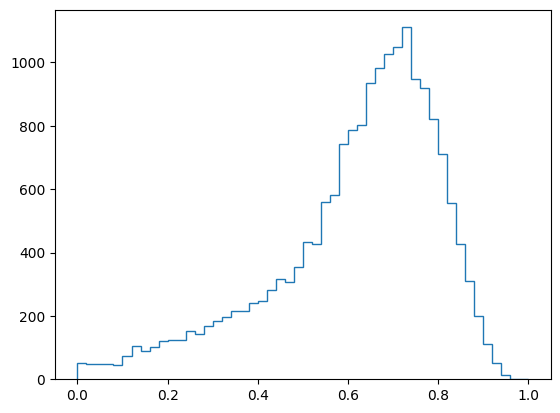

In [33]:
import matplotlib.pyplot as plt

values, edges=np.histogram(coverage, bins=50,range=(0,1))
patch = plt.stairs(values, edges)

In [29]:
np.count_nonzero(mapping==inverse_benchmark)

9327